
# Step 2 — Black‑Box Model (XGBoost) for Default Prediction

This notebook trains an XGBoost classifier to forecast **default** (binary `target`) for the course project **Interpretability, Stability, and Algorithmic Fairness (Fall 2025)**.

**What this notebook does**
- Loads the project dataset
- Cleans & preprocesses features (numeric + categorical)
- Trains an XGBoost model with early stopping
- Evaluates with ROC‑AUC, PR‑AUC, F1, confusion matrix
- Saves predictions and the fitted model for later steps

> Note: Columns that could leak information from Step 1 (e.g., `'Predictions'`, `'Predicted probabilities'`) are **dropped** on load.


## 0. Setup

In [1]:

# If needed, install dependencies (uncomment as necessary)
# %pip install -q xgboost scikit-learn pandas numpy matplotlib joblib

import os
import gc
import math
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve,
    roc_curve, classification_report, confusion_matrix
)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## 1. Configuration

In [2]:

# --- Paths ---
# Prefer a local file first; fall back to /mnt/data if running in a hosted environment.

DATA_PATH = '/Users/chenzhipeng/Desktop/X/Cours/Interpretability/group_project/Algo_fairness-Group-Project/data/raw/dataproject2025.csv'

# --- Basic run params ---
TEST_SIZE = 0.20            # 80/20 stratified split
USE_SAMPLE = False          # set True for quick tests (e.g., 50_000 rows)
SAMPLE_N = 50_000

# Whether to EXCLUDE sensitive attributes from features (you can toggle later for Step 9 fairness analysis)
EXCLUDE_SENSITIVE = False
SENSITIVE_COLS = [
    "Pct_afro_american"    # protected attribute proxy provided in the dataset
]

print(f"Using DATA_PATH = {DATA_PATH}")


Using DATA_PATH = /Users/chenzhipeng/Desktop/X/Cours/Interpretability/group_project/Algo_fairness-Group-Project/data/raw/dataproject2025.csv


## 2. Load data

In [3]:

# Read CSV (large-friendly). We'll downcast floats to float32 to reduce memory.
read_kwargs = dict(low_memory=False)
df = pd.read_csv(DATA_PATH, **read_kwargs)

if USE_SAMPLE and len(df) > SAMPLE_N:
    df = df.sample(SAMPLE_N, random_state=RANDOM_STATE).reset_index(drop=True)

print(df.shape)
display(df.head(3))
print("\nColumns:", list(df.columns))


(1086236, 39)


,Unnamed: 0,issue_d,loan duration,annual_inc,avg_cur_bal,bc_open_to_buy,bc_util,delinq_2yrs,dti,emp_length,...,purpose,revol_bal,revol_util,sub_grade,target,tax_liens,zip_code,Pct_afro_american,Predictions,Predicted probabilities
0,0,2013,0,39600.0,1379.0,21564.0,16.1,0.0,2.49,2 years,...,home_improvement,4136.0,16.1,B2,0,0.0,782,7.388592,0,0.053051
1,1,2013,0,55000.0,9570.0,16473.0,53.9,0.0,22.87,10+ years,...,debt_consolidation,36638.0,61.2,B2,0,0.0,481,9.745456,0,0.084507
2,2,2013,0,325000.0,53306.0,13901.0,67.1,0.0,18.55,5 years,...,debt_consolidation,29581.0,54.6,A3,0,0.0,945,7.542862,0,0.037206



Columns: ['Unnamed: 0', 'issue_d', 'loan duration', 'annual_inc', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'delinq_2yrs', 'dti', 'emp_length', 'emp_title', 'fico_range_high', 'funded_amnt', 'grade', 'home_ownership', 'inq_last_6mths', 'int_rate', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'num_actv_bc_tl', 'num_bc_tl', 'num_il_tl', 'num_rev_accts', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'target', 'tax_liens', 'zip_code', 'Pct_afro_american', 'Predictions', 'Predicted probabilities']


## 3. Basic cleaning & target

In [4]:

# Drop known leak / index columns if present
LEAKY_COLS = [
    "Predictions", "Predicted probabilities", "DP", "dp", 
    "Unnamed: 0", "id", "ID", "index"
]
present_leaky = [c for c in LEAKY_COLS if c in df.columns]
df = df.drop(columns=present_leaky, errors="ignore")

# Target
assert "target" in df.columns, "Expected 'target' column not found."
df["target"] = df["target"].astype(int)

# Optional: exclude sensitive columns for Step 2 (toggle above)
if EXCLUDE_SENSITIVE:
    drop_sens = [c for c in SENSITIVE_COLS if c in df.columns]
    if drop_sens:
        df = df.drop(columns=drop_sens)

print("After drops:", df.shape)
df.head(2)


After drops: (1086236, 36)


,issue_d,loan duration,annual_inc,avg_cur_bal,bc_open_to_buy,bc_util,delinq_2yrs,dti,emp_length,emp_title,...,pub_rec,pub_rec_bankruptcies,purpose,revol_bal,revol_util,sub_grade,target,tax_liens,zip_code,Pct_afro_american
0,2013,0,39600.0,1379.0,21564.0,16.1,0.0,2.49,2 years,other,...,0.0,0.0,home_improvement,4136.0,16.1,B2,0,0.0,782,7.388592
1,2013,0,55000.0,9570.0,16473.0,53.9,0.0,22.87,10+ years,other,...,0.0,0.0,debt_consolidation,36638.0,61.2,B2,0,0.0,481,9.745456


## 4. Feature engineering

In [5]:

def parse_emp_length(val):
    '''
    Convert employment length strings to numeric years.
    Examples: '10+ years'->10, '< 1 year'->0.5, '3 years'->3, NaN->np.nan
    '''
    if pd.isna(val):
        return np.nan
    s = str(val).strip().lower()
    if s in {"< 1 year", "less than 1 year", "<1 year"}:
        return 0.5
    if s in {"10+ years", "10+ yrs", "10+yr"}:
        return 10.0
    # Extract any leading integer
    for tok in s.replace("+","").split():
        try:
            return float(int(tok))
        except:
            continue
    try:
        return float(s)
    except:
        return np.nan

def parse_loan_duration(val):
    '''
    Convert '36 months' -> 36, '60 months' -> 60, already numeric -> itself.
    '''
    if pd.isna(val):
        return np.nan
    if isinstance(val, (int, float)):
        return float(val)
    s = str(val).strip().lower().replace("months","").replace("month","").strip()
    try:
        return float(s)
    except:
        return np.nan

# Apply parsers if columns exist
if "emp_length" in df.columns:
    df["emp_length_parsed"] = df["emp_length"].apply(parse_emp_length)
if "loan duration" in df.columns:
    df["loan_duration_parsed"] = df["loan duration"].apply(parse_loan_duration)

# If 'issue_d' is a date-like string or year, keep numeric
if "issue_d" in df.columns:
    # If looks numeric (e.g., 2013.0), keep as float; else parse to ordinal
    if df["issue_d"].dtype == object:
        try:
            d = pd.to_datetime(df["issue_d"], errors="coerce")
            df["issue_d_ordinal"] = d.map(lambda x: x.toordinal() if pd.notna(x) else np.nan)
        except:
            pass
    else:
        # leave numeric year/month values as-is
        pass

# Identify feature columns
target_col = "target"
all_features = [c for c in df.columns if c != target_col]

# Separate numeric vs categorical by dtype (object -> categorical). We'll skip free-text high-cardinality fields.
high_cardinality_text = {"emp_title"}  # can revisit with hashing later
features = [c for c in all_features if c not in high_cardinality_text]

numeric_cols = [c for c in features if pd.api.types.is_numeric_dtype(df[c])]
categorical_cols = [c for c in features if c not in numeric_cols]

print("Numeric:", len(numeric_cols), "Categorical:", len(categorical_cols))


Numeric: 31 Categorical: 5


## 5. Train / validation split

In [6]:

X = df[numeric_cols + categorical_cols].copy()
y = df[target_col].copy()

# Ensure numeric types are float32 to reduce memory footprint
for c in numeric_cols:
    X[c] = pd.to_numeric(X[c], errors="coerce").astype("float32")

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)

print("Train:", X_train.shape, " Test:", X_test.shape)
print("Default rate (train):", y_train.mean().round(4), " (test):", y_test.mean().round(4))


Train: (868988, 36)  Test: (217248, 36)
Default rate (train): 0.2105  (test): 0.2105


## 6. Model: XGBoost

In [7]:
# Preprocess
numeric_transformer = SimpleImputer(strategy="median")

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ],
    sparse_threshold=0.3  # keep sparse matrices when many categories
)

# Class imbalance handling via scale_pos_weight = (neg/pos)
pos = y_train.sum()
neg = len(y_train) - pos
scale_pos_weight = float(neg / max(pos, 1))

xgb = XGBClassifier(
    n_estimators=2000,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=1.0,
    min_child_weight=1.0,
    objective="binary:logistic",
    tree_method="hist",
    random_state=RANDOM_STATE,
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    early_stopping_rounds=50
)

# Early stopping with a validation split
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.15, stratify=y_train, random_state=RANDOM_STATE
)

model = Pipeline(steps=[
    ("prep", preprocess),
    ("xgb", xgb)
])

# Fit with early stopping (pass eval_set to underlying xgb via fit_params)
# We need to transform X_val with the preprocessor to feed to xgb for eval_set
prep = preprocess.fit(X_tr, y_tr)
X_tr_t = prep.transform(X_tr)
X_val_t = prep.transform(X_val)

xgb.fit(
    X_tr_t, y_tr, # Using your transformed data
    eval_set=[(X_val_t, y_val)],
    verbose=False, # Control verbosity here
  #  callbacks=[EarlyStopping(rounds=50)] # Callback only needs the number of rounds
)

# Wrap back into a single pipeline for convenience (prep is already fitted; xgb is fitted).
from sklearn.base import BaseEstimator, TransformerMixin
class PretrainedPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, fitted_preprocessor):
        self.fitted = fitted_preprocessor
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return self.fitted.transform(X)

final_model = Pipeline(steps=[
    ("prep", PretrainedPreprocessor(prep)),
    ("xgb", xgb)
])

try:
    best_ntree = xgb.get_booster().best_ntree_limit
except Exception:
    best_ntree = "n/a"
print("Best n_estimators (limit):", best_ntree)


Best n_estimators (limit): n/a


## 7. Evaluation

ROC-AUC: 0.7237 | PR-AUC: 0.4114

              precision    recall  f1-score   support

           0     0.8788    0.6692    0.7598    171518
           1     0.3451    0.6538    0.4518     45730

    accuracy                         0.6660    217248
   macro avg     0.6119    0.6615    0.6058    217248
weighted avg     0.7664    0.6660    0.6950    217248

Confusion Matrix:
 [[114782  56736]
 [ 15832  29898]]


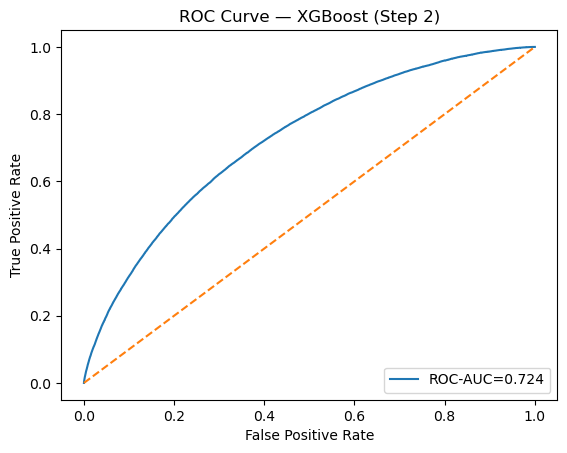

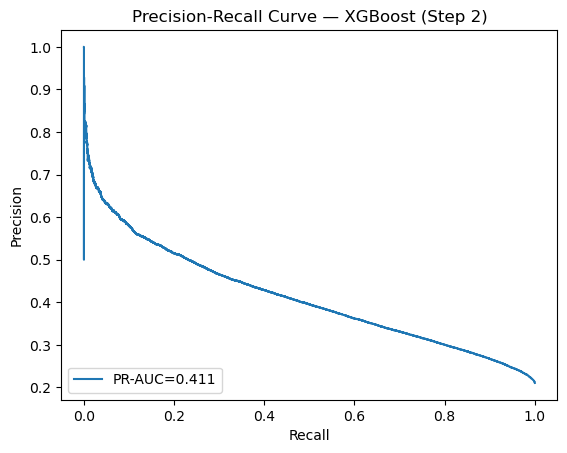

In [8]:

# Predict
X_test_t = prep.transform(X_test)
proba = xgb.predict_proba(X_test_t)[:, 1]
pred = (proba >= 0.5).astype(int)

# Metrics
roc_auc = roc_auc_score(y_test, proba)
pr_auc = average_precision_score(y_test, proba)
print(f"ROC-AUC: {roc_auc:.4f} | PR-AUC: {pr_auc:.4f}\n")

print(classification_report(y_test, pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_test, pred)
print("Confusion Matrix:\n", cm)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, proba)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC-AUC={roc_auc:.3f}")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — XGBoost (Step 2)")
plt.legend(loc="lower right")
plt.show()

# PR Curve
prec, rec, _ = precision_recall_curve(y_test, proba)
plt.figure()
plt.plot(rec, prec, label=f"PR-AUC={pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve — XGBoost (Step 2)")
plt.legend(loc="lower left")
plt.show()


## 8. Feature importance (gain)

,feature,gain
42,grade_A,723.415771
30,loan_duration_parsed,489.243073
43,grade_B,286.718414
11,int_rate,250.401810
1,loan duration,245.430176
44,grade_C,186.161560
51,home_ownership_RENT,78.122635
0,issue_d,64.563080
45,grade_D,54.261425
49,home_ownership_MORTGAGE,46.636276


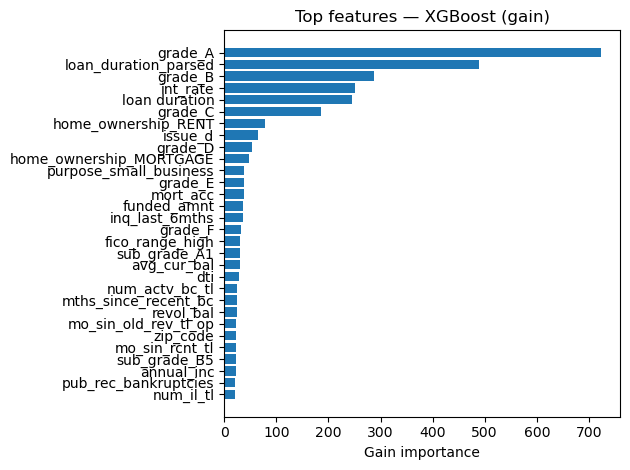

In [9]:

# Map feature names through the fitted preprocessor (OHE expands categories)
ohe = prep.named_transformers_["cat"].named_steps["ohe"] if len(categorical_cols) else None
num_feature_names = numeric_cols
cat_feature_names = list(ohe.get_feature_names_out(categorical_cols)) if ohe is not None else []
feature_names = list(num_feature_names) + cat_feature_names

booster = xgb.get_booster()
# XGBoost importance is keyed by f0, f1, ...
score_map = booster.get_score(importance_type="gain")

# Convert to a sorted DataFrame
imp = pd.DataFrame(
    [(int(k[1:]), v) for k,v in score_map.items()],
    columns=["index","gain"]
).sort_values("gain", ascending=False)

imp["feature"] = imp["index"].map(lambda i: feature_names[i] if i < len(feature_names) else f"f{i}")
topk = imp.head(30)[["feature","gain"]]
display(topk)

plt.figure()
plt.barh(topk["feature"][::-1], topk["gain"][::-1])
plt.xlabel("Gain importance")
plt.title("Top features — XGBoost (gain)")
plt.tight_layout()
plt.show()


## 9. Save artifacts

In [10]:
import datetime
out_dir = "outputs_step2"
os.makedirs(out_dir, exist_ok=True)

model_path = os.path.join(out_dir, "xgb_step2_model.joblib")
preds_path = os.path.join(out_dir, "xgb_step2_test_predictions.csv")
meta_path  = os.path.join(out_dir, "xgb_step2_meta.txt")

# Save model and predictions
joblib.dump(final_model, model_path)


preds_df = pd.DataFrame({
    "y_true": y_test.values,
    "y_proba": proba,
    "y_pred": pred
})
preds_df.to_csv(preds_path, index=False)

with open(meta_path, "w") as f:
    f.write(f"Saved: {datetime.datetime.now().isoformat()}\n")
    f.write(f"Data path: {DATA_PATH}\n")
    f.write(f"Train shape: {X_train.shape} | Test shape: {X_test.shape}\n")
    f.write(f"ROC-AUC: {roc_auc:.6f} | PR-AUC: {pr_auc:.6f}\n")
    f.write(f"Scale_pos_weight: {scale_pos_weight}\n")
    f.write(f"Excluded sensitive cols: {EXCLUDE_SENSITIVE}\n")

print("Artifacts saved to:", out_dir)
print(" -", model_path)
print(" -", preds_path)
print(" -", meta_path)


Artifacts saved to: outputs_step2
 - outputs_step2/xgb_step2_model.joblib
 - outputs_step2/xgb_step2_test_predictions.csv
 - outputs_step2/xgb_step2_meta.txt



## 10. SHAP Analysis


In [ ]:
# 1. Initialize Explainer
# For tree-based models (e.g., XGBoost), use TreeExplainer
# Since your XGBoost model was trained directly on sparse matrix/NumPy arrays X_tr_t/X_val_t,
# we will directly use xgb.get_booster() with TreeExplainer.
# If the dataset is very large, you can sample X_test_t to speed up computation.
# Here we first use the entire test set; if the runtime is too long, you should ask me about sampling.

# Check if shap is installed
try:
    import shap
except ImportError:
    print("SHAP library not found. Please run: %pip install shap")
    exit()

# Since XGBoost was trained on sparse matrices, TreeExplainer can handle them efficiently
explainer = shap.TreeExplainer(
    model=xgb,
    data=X_test_t # Provide data to compute background/baseline. Although TreeExplainer usually does not need it, it helps with more accurate baseline calculation
)

# 2. Calculate Shapley values
# Shapley values matrix (shape: (n_samples, n_features))
print("Starting SHAP value calculation for test set (this may take a moment)...")


Starting SHAP value calculation for test set (this may take a moment)...


In [ ]:
# For binary classification, shap_values is a list containing two arrays [shap_class_0, shap_class_1]
# We focus on default probability (target=1), so use index 1
shap_values = explainer.shap_values(X_test_t)
# Core assignment part (replace the original shap_values_class1 = shap_values[1])
try:
    # Try standard SHAP output: list [Class 0, Class 1]
    shap_values_class1 = shap_values[1] 
    # Check if we successfully got a 2D array; if shap_values[1] is still 1D, raise exception
    if shap_values_class1.ndim < 2:
        raise IndexError
except:
    # If failed, assume shap_values is already a 2D matrix for Class 1
    shap_values_class1 = shap_values
print("SHAP values calculation complete.")


# 4. Convert transformed data into DataFrame for easier visualization
# --- Bug fix START ---
# Check if X_test_t is a sparse matrix, if so convert to dense array (.toarray())
if hasattr(X_test_t, 'toarray'):
    X_test_dense = X_test_t.toarray()
else:
    X_test_dense = X_test_t
# --- Bug fix END ---

X_test_df = pd.DataFrame(X_test_dense, columns=feature_names)


# 5. Local interpretability visualization: Force Plot (show contribution of a single sample)

# Goal: explain a **specific** sample.
sample_index = 0 # Example: choose the first sample in the test set
target_value = y_test.iloc[sample_index]
predicted_proba = proba[sample_index]

print(f"\n--- Local Interpretation for Sample {sample_index} ---")
print(f"True Target: {target_value}, Predicted Proba (Default): {predicted_proba:.4f}")

100%|===================| 217232/217248 [199:23<00:00]        

SHAP values calculation complete.

--- Local Interpretation for Sample 0 ---
True Target: 0, Predicted Proba (Default): 0.6658


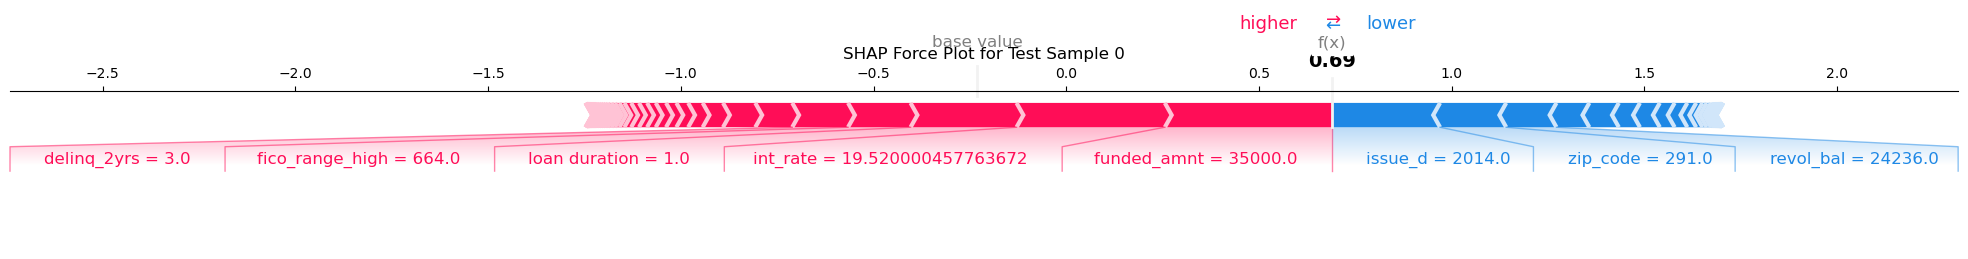


--- Global Interpretation (SHAP Summary Plot) ---


/var/folders/9w/p05jm_tx23x74f6jlkqv6k9w0000gn/T/ipykernel_1242/3686564790.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


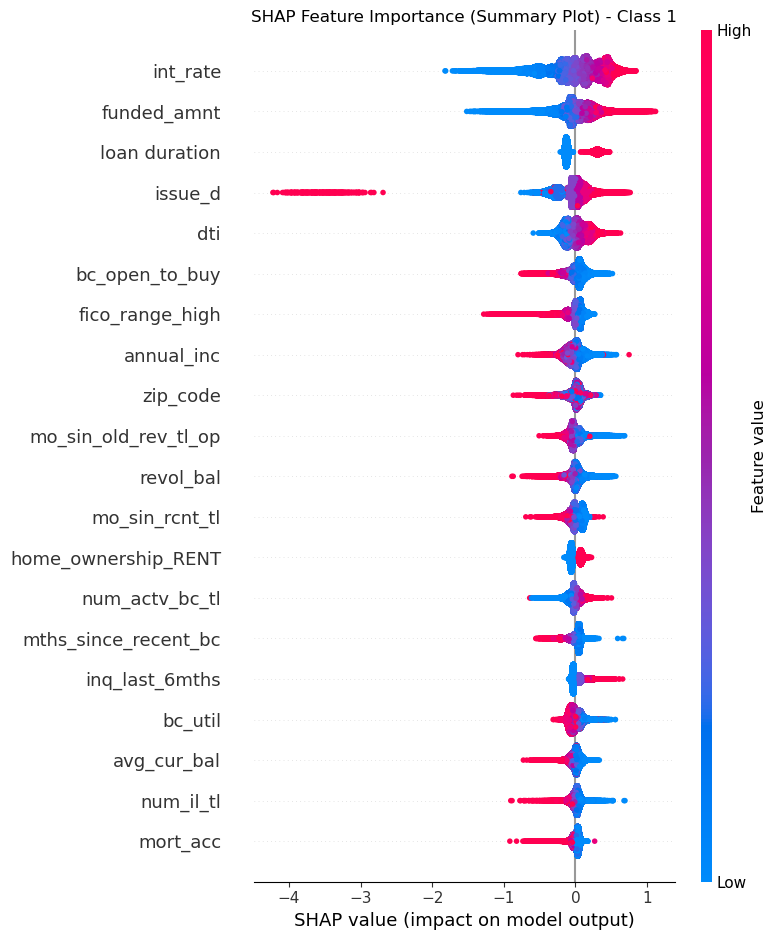


--- Global Interpretation (SHAP Bar Plot) ---


/var/folders/9w/p05jm_tx23x74f6jlkqv6k9w0000gn/T/ipykernel_1242/3686564790.py:29: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


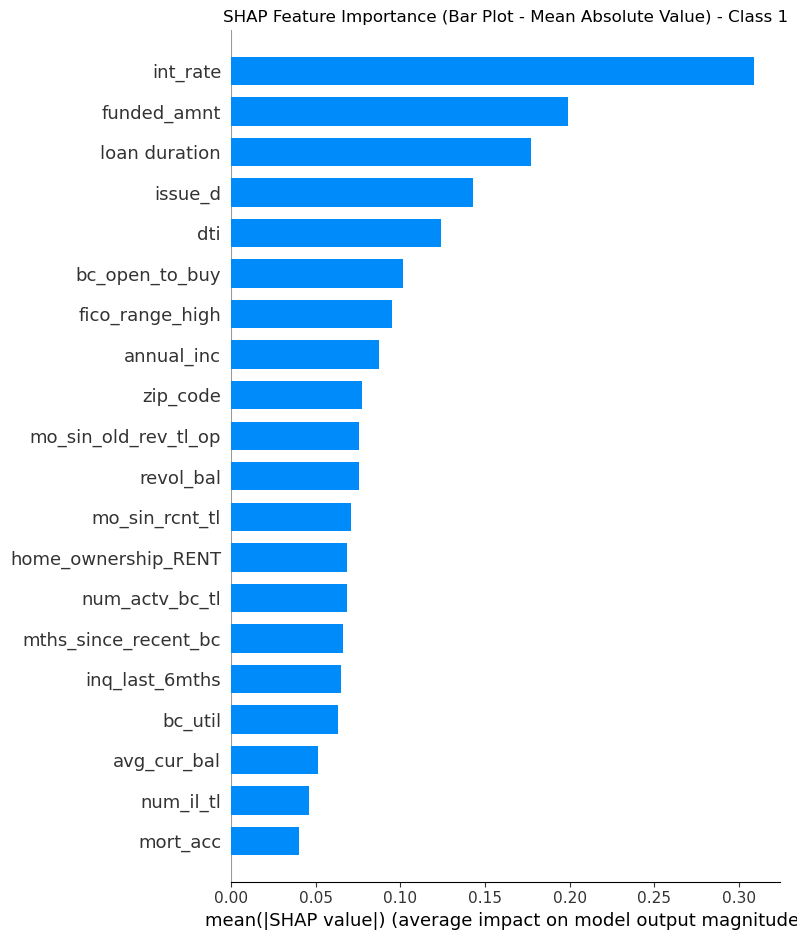

In [ ]:
# Force Plot: show how features push the base value towards the final prediction on the log-odds scale
# explainer.expected_value[1] is the base value
shap.force_plot(
    explainer.expected_value, 
    shap_values_class1[sample_index, :], # cut off the last column
    X_test_df.iloc[sample_index, :],
    matplotlib=True,
    show=False
)
plt.title(f"SHAP Force Plot for Test Sample {sample_index}")
plt.tight_layout()
plt.show()

# 6. Global interpretability visualization: Summary Plot (show overall impact and direction)
# This is the most important SHAP global view, showing the distribution of Shapley values and impact direction for each feature.
print("\n--- Global Interpretation (SHAP Summary Plot) ---")
shap.summary_plot(
    shap_values_class1,
    X_test_df,
    feature_names=feature_names,
    show=False
)
plt.title("SHAP Feature Importance (Summary Plot) - Class 1")
plt.tight_layout()
plt.show()

# 7. Global interpretability visualization: Bar Plot (ranked by mean absolute contribution)
print("\n--- Global Interpretation (SHAP Bar Plot) ---")
shap.summary_plot(
    shap_values_class1,
    X_test_df,
    plot_type="bar",
    show=False
)
plt.title("SHAP Feature Importance (Bar Plot - Mean Absolute Value) - Class 1")
plt.tight_layout()
plt.show()